### Nonogram class

In [1]:
from typing import List, Tuple
import random
import numpy as np
import itertools
import math
import re

In [2]:
def pad(list, target_len):
    return [0]*(target_len - len(list)) + list[:target_len]

In [3]:
class Nonogram():
    display_char = {
        -1: "?",
        0: "□",
        1: "■"
    }

    def __init__(self,
                 row_count: int,
                 col_count: int,
                 row_descriptors: List[List[int]] = None,
                 col_descriptors: List[List[int]] = None,
                 colored_cells: List[Tuple[int]] = None):
        self.row_count = row_count
        self.col_count = col_count

        self.row_descriptor_len = math.ceil(col_count / 2)
        self.col_descriptor_len = math.ceil(row_count / 2)

        if not row_descriptors:
            row_descriptors = [[] for _ in range(row_count)]
        if not col_descriptors:
            col_descriptors = [[] for _ in range(col_count)]

        self.row_descriptors = [pad(row, self.row_descriptor_len)
                                for row in row_descriptors]
        self.col_descriptors = [pad(col, self.col_descriptor_len)
                                for col in col_descriptors]

        self.reset_cells()

        if colored_cells:
            self.colored_cells = colored_cells

    def reset_cells(self):
        self.cells = np.ones((self.row_count, self.col_count), dtype=int) * -1

    @property
    def colored_cells(self) -> List[Tuple[int]]:
        solutions = []
        for i in range(len(self.row_descriptors)):
            for j in range(len(self.col_descriptors)):
                if self.cells[i][j] == 1:
                    solutions.append((i, j))
        return solutions

    @colored_cells.setter
    def colored_cells(self, solutions):
        for i in range(self.row_count):
            for j in range(self.col_count):
                self.cells[i][j] = 1 if (i, j) in solutions else 0

    def print(self, show_zeros=False) -> None:
        row_descriptor_len = self.row_descriptor_len
        col_descriptor_len = self.col_descriptor_len

        output = ""

        # column numbers
        for i in range(col_descriptor_len-1, -1, -1):
            output += "  " * row_descriptor_len
            for col in self.col_descriptors:
                output += str(col[-(i+1)]) + " " if len(col) > i else "  "

            output += "\n"

        # row numbers
        for i, row in enumerate(self.row_descriptors):
            for r in range(row_descriptor_len-1, -1, -1):
                output += str(row[-(r+1)]) + " " if len(row) > r else "  "

            # body
            for j, col in enumerate(self.col_descriptors):
                output += Nonogram.display_char[self.cells[i][j]] + " "

            output += "\n"

        # don't display 0 values
        if not show_zeros:
            output = re.sub(r"(?<=[^0-9])0", " ", output)
        print(output)

    def is_solved(self) -> bool:
        if np.isin(-1, self.cells):
            return False

        real_row_descriptors = self.__calculate_row_descriptors()

        if real_row_descriptors != self.row_descriptors:
            return False

        real_col_descriptors = self.__calculate_col_descriptors()

        if real_col_descriptors != self.col_descriptors:
            return False

        return True

    def calculate_descriptors(self):
        self.row_descriptors = self.__calculate_row_descriptors()
        self.col_descriptors = self.__calculate_col_descriptors()

        return self.row_descriptors, self.col_descriptors

    def __calculate_row_descriptors(self):
        row_descriptors = []

        for row in self.cells:
            row_descriptors.append(self.__calculate_descriptor(row))

        return row_descriptors

    def __calculate_col_descriptors(self):
        col_descriptors = []

        for col in self.cells.T:
            col_descriptors.append(self.__calculate_descriptor(col))

        return col_descriptors

    def __calculate_descriptor(self, list: List[int]):
        descriptor = []
        open_piece = False
        pad_len = math.ceil(len(list) / 2)

        for elem in list:
            if elem == 1:
                if open_piece:
                    descriptor[-1] += 1
                else:
                    descriptor.append(1)
                    open_piece = True
            else:
                open_piece = False

        return pad(descriptor, pad_len)

    def solve_line(self, index: int):
        if index < self.row_count:
            row = self.cells[index]
            row_descriptor = self.row_descriptors[index]

            solved_row = self.__solve_line(row, row_descriptor)
            reward = np.sum(row == -1) - np.sum(solved_row == -1)

            self.cells[index] = solved_row
            return reward
        else:
            index -= self.row_count
            col = self.cells[:, index]
            col_descriptor = self.col_descriptors[index]

            solved_col = self.__solve_line(col, col_descriptor)
            reward = np.sum(col == -1) - np.sum(solved_col == -1)

            self.cells[:, index] = solved_col
            return reward

    def __solve_line(self, line, line_descriptor):
        # More efficient algorithm could be implemented
        possible_lines = []
        filled_cell_count = sum(line_descriptor)

        line_indexes = range(len(line))

        for filled_indexes in itertools.combinations(line_indexes, filled_cell_count):
            possible_solution = [0 for _ in range(len(line))]

            for i in filled_indexes:
                possible_solution[i] = 1

            if pad(self.__calculate_descriptor(possible_solution),
                   len(line_descriptor)) == line_descriptor:

                matches_line = True
                for r, s in zip(line, possible_solution):
                    if r != -1 and r != s:
                        matches_line = False
                        break

                if matches_line:
                    possible_lines.append(np.array(possible_solution))

        result = [True] * len(possible_lines[0])
        last_line = possible_lines[0]

        for curr_line in possible_lines:
            for i, (curr, last) in enumerate(zip(curr_line, last_line)):
                if curr != last:
                    result[i] = False
            last_line = curr_line

        solved_line = [e if result[i] else -1 for i,
                       e in enumerate(possible_lines[0])]

        return solved_line

### Generating data

In [4]:
def random_nonogram(row_count, col_count) -> Nonogram:
    cell_count = row_count*col_count

    # nonograms with half of the cells colored are the hardest
    colored_cell_count = np.random.binomial(cell_count, 0.5)

    fields = list(itertools.product(range(row_count), range(col_count)))

    colored_fields = random.sample(fields, k=colored_cell_count)

    nonogram = Nonogram(
        row_count,
        col_count,
        colored_cells=colored_fields)

    nonogram.calculate_descriptors()

    return nonogram

In [5]:
ROWS = 4
COLS = 4

In [6]:
nonogram = random_nonogram(ROWS, COLS)

nonogram.print()

    2     2 
    1 3 2 1 
1 1 ■ □ □ ■ 
2 1 ■ ■ □ ■ 
  2 □ ■ ■ □ 
  4 ■ ■ ■ ■ 



In [7]:
nonograms = [random_nonogram(ROWS, COLS) for _ in range(200000)]

In [8]:
TRAIN_SPLIT = 0.7
VALID_SPLIT = 0.2
N = len(nonograms)

train_nonograms = nonograms[:int(N*TRAIN_SPLIT)]
valid_nonograms = nonograms[int(N*TRAIN_SPLIT):int(N*(TRAIN_SPLIT+VALID_SPLIT))]
test_nonograms = nonograms[int(N*(TRAIN_SPLIT+VALID_SPLIT)):]

In [9]:
def x_from_nonogram(nonogram: Nonogram):
  flat_row_descriptor = np.array(nonogram.row_descriptors).flatten()
  flat_col_descriptor = np.array(nonogram.col_descriptors).flatten()
  
  return np.concatenate((flat_row_descriptor, flat_col_descriptor))

In [10]:
def y_from_nonogram(nonogram: Nonogram):
  return np.array(nonogram.cells).flatten()

In [11]:
x_train = np.array([x_from_nonogram(n) for n in train_nonograms])
y_train = np.array([y_from_nonogram(n) for n in train_nonograms])

x_valid = np.array([x_from_nonogram(n) for n in valid_nonograms])
y_valid = np.array([y_from_nonogram(n) for n in valid_nonograms])

### Creating the model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from datetime import datetime

In [13]:
model = Sequential()
model.add(Dense(8, input_dim=x_train.shape[1], kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

optimizer = Adam(learning_rate=0.1)
model.compile(loss='mae', optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
Total params: 6,552
Trainable params: 6,552
Non-trainable params: 0
_________________________________________________________________


### Traning

In [15]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

In [16]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [18]:
# Define callbacks
tb = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=1)
early_stopping = EarlyStopping(patience=20, verbose=1)
checkpoint = ModelCheckpoint(filepath='dense_model_best',
                             save_best_only=True, verbose=1)

In [19]:
model.fit(x_train, y_train, 
          validation_data=(x_valid, y_valid),
          batch_size=256, epochs=3000,
          callbacks=[tb, early_stopping, checkpoint], verbose=2)

Epoch 1/3000
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch 00001: val_loss improved from inf to 0.21648, saving model to dense_model_best
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dense_model_best/assets
547/547 - 2s - loss: 0.2921 - val_loss: 0.2165
Epoch 2/3000

Epoch 00002: val_loss improved from 0.21648 to 0.19218, saving model to dense_model_best
INFO:tensorflow:Assets written to: dense_model_best/assets
547/547 - 2s - loss: 0.2012 - val_loss: 0.1922
Epoch 3/3000

Epoch 00003: val_loss improved from 0.19218 to 0.18627, saving model to dense_model_best
INFO:tensorflow:Assets written to: dense_model_best/assets
547/547 - 2s - loss: 0.1894 - val_loss: 0.1863
Epoch 4/3000

Epoch 00004: val_loss improved from 0.18627 to 0.18285, s

KeyboardInterrupt: ignored

### Load saved model

In [21]:
from google.colab import drive
from tensorflow.keras.models import load_model

In [77]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
MODEL_PATH = 'dense_model_best'

model = load_model(MODEL_PATH)

### Evaluate model

In [23]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [24]:
x_test = np.array([x_from_nonogram(n) for n in test_nonograms])
y_test = np.array([y_from_nonogram(n) for n in test_nonograms])

In [25]:
y_predicted = model.predict(x_test)
y_predicted = np.rint(y_predicted).astype(int)

In [26]:
missed_cells = []

for predicted_cells, real_cells in zip(y_predicted, y_test):
  mae = mean_absolute_error(predicted_cells, real_cells)

  missed_cells.append(int(mae*len(real_cells)))

correct_guesses = len([c for c in missed_cells if c == 0])

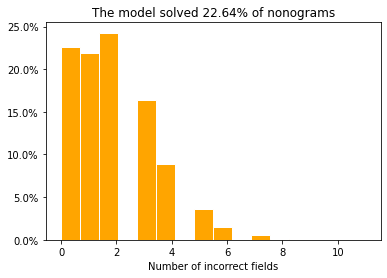

In [27]:
plt.hist(missed_cells, 
         bins=y_predicted.shape[1],
         weights=np.ones(len(missed_cells)) / len(missed_cells),
         edgecolor='white', color='orange')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title(f'The model solved {100*correct_guesses/len(missed_cells):.2f}% of nonograms')
plt.xlabel('Number of incorrect fields')
plt.show();